In [1]:
import spacy
# Análisis de componentes principales
from sklearn.decomposition import PCA
# Clustering jerárquico
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# Nubes de palabras
from wordcloud import WordCloud

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob, os

In [3]:
# Descomentar esta línea para descargar los embeddings españoles
# !python -m spacy download es_core_news_md
# Modelo con embeddings
nlp = spacy.load('es_core_news_md')

In [64]:
import pandas as pd
pregs = pd.read_csv('Cuestionario.csv')
# Quitar la fila 63, que no tiene respuestas
pregs.drop(63, inplace=True)
pregs.head()

,Marca temporal,1. ¿Cuál crees que es el papel de un psicólogo?,2. ¿Qué es la inteligencia emocional?,3. ¿Qué es para ti la felicidad?,4. ¿Qué es la depresión?,5. ¿Por qué se puede llegar a tener una depresión?,6. ¿Cómo podría un psicólogo ayudar a alguien que necesita ayuda pero que no quiere ser ayudado?,7. ¿Cuáles crees que son las enfermedades psicológicas más frecuentes?,8. ¿Cuáles son las causas por las que crees que hay gente que se suicida?,9. ¿Cuáles son las diferencias que crees que hay entre un psicólogo y un psiquiatra?,10. ¿En qué casos acudirías al psicólogo?
0,2019/05/02 11:53:31 p. m. EET,Orientar,La que te hace recordar los buenos momentos,Satisfacción por el logro,No saber afrontar el hechop,Por que no te escuchen,Animarlo educarlo que se puede conseguir,La mente del alzehimer,No afrontar que está hundido,Distintas el psiquiatra estudia el problema el...,Cuando nadie me ayude
1,2019/05/03 12:28:52 a. m. EET,Salud emocional,Empatía y sentido común,Libertad y actividad,Falta de espíritu y estímulos,Respuesta 4,Manipulándolo,Ciclotimia,No encontrar salidas o sentido a la vida,"Siquiatra es médico, con todo lo que implica",Inestabilidad emocional
2,2019/05/03 12:29:00 a. m. EET,Salud emocional,Empatía y sentido común,Libertad y actividad,Falta de espíritu y estímulos,Respuesta 4,Manipulándolo,Ciclotimia,No encontrar salidas o sentido a la vida,"Siquiatra es médico, con todo lo que implica",Inestabilidad emocional
3,2019/05/03 12:48:31 a. m. EET,Guiar a una persona perdida para racionalizar ...,Saber leer nuestras emociones y poder gestiona...,Disfrutar de lo que se tiene y no tener en cue...,"No saber gestionar las emociones negativas, si...",Por no saber gestionar nuestras emociones,Haciendo ver el significado de lo que dicen su...,Depresión y adicciones,Desesperación y no ver salida a los problemas,Un psicólogo te hace entender lo que te pasa y...,"Adicción, problemas de comportamiento, depresi..."
4,2019/05/03 12:51:11 a. m. EET,Ayudar,Capacidad de gestionar emociones,Estar a gusto conmigo mismo,Estar mal,Por diversos factores que alteran nuestro estado,Indirectamente,"Depresión, ansiedad",Son muy distintas,El psicólogo no receta medicación,Si quisiera hablar con alguien


In [7]:
def texto_pregunta(df, indice):
    ''' Devuelve todas las respuestas a una pregunta determinada '''
    txt = '\n'.join(list(df.iloc[:, indice].dropna()))
    return txt

In [11]:
def texto_persona(df, indice):
    ''' Devuelve las respuestas de una persona determinada a todas las preguntas '''
    txt = '\n'.join(list(df.iloc[indice, 1:].dropna()))
    return txt

In [67]:
# Pasamos todas las preguntas y todas las personas por el modelo que hemos descargado
resps = [nlp(texto_pregunta(pregs, r)) for r in range(1, pregs.shape[1])]
pers = [nlp(texto_persona(pregs, p)) for p in range(pregs.shape[0])]
len(resps), len(pers)

(10, 80)

In [68]:
# Hay un vector pre-entrenado (word embedding) asociado con cada palabra española
# y un vector que representa la media de todos los vectores de palabra
# en cada documento

# Almacenamos todos los vectores de respuestas en una matriz
v_resps = np.vstack([t.vector for t in resps])
# Y los de personas en otra
v_pers = np.vstack([t.vector for t in pers])

In [69]:
# Clustering jerárquico de los vectores de respuestas
lnk_resps = linkage(v_resps, method='ward')
# Clustering jerárquico de los vectores de personas
lnk_pers = linkage(v_pers, method='ward')

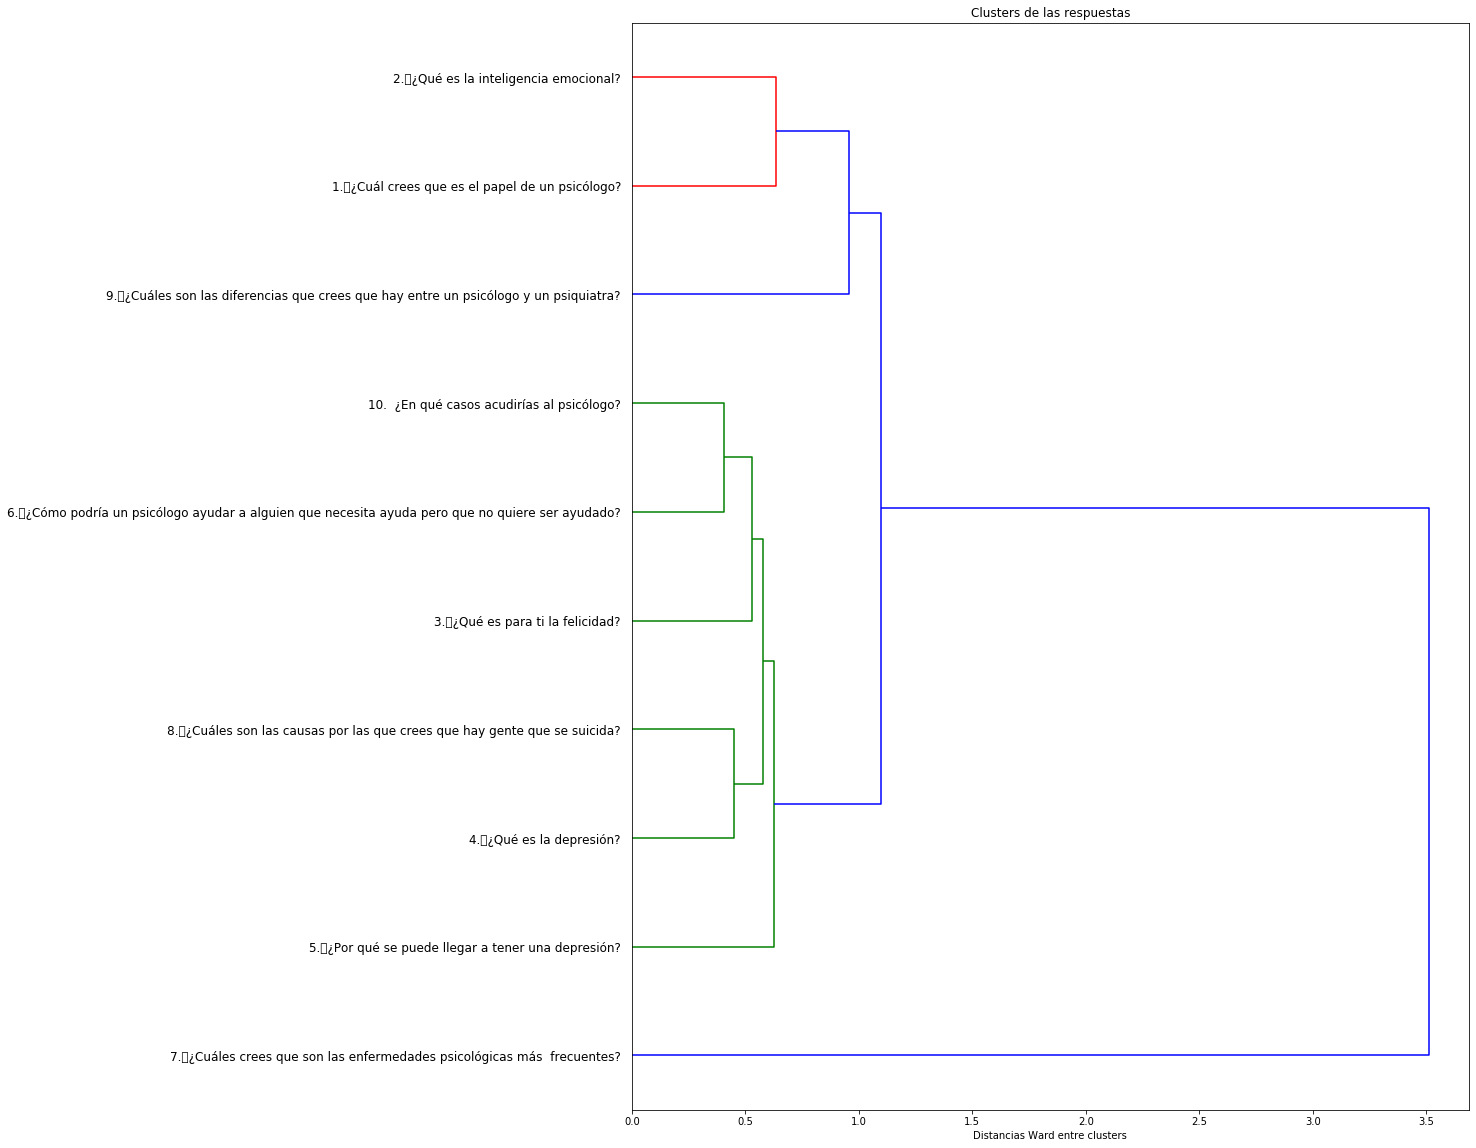

In [70]:
# Dendrograma de las respuestas

# Elegimos una distancia de corte
# para resaltar los clusters principales
dist_corte_resps = 0.8

fig, ax = plt.subplots(figsize=(15, 20))
opciones = {'ax': ax, 'orientation': "right", 'labels': pregs.columns[1:],
            'p': 5, 'color_threshold': dist_corte_resps,
           }
plt.title('Clusters de las respuestas')
plt.xlabel('Distancias Ward entre clusters')
dendrogram(lnk_resps, **opciones)
# Guardamos la imagenresps_
plt.savefig('figuras/dendrograma_respuestas.png', dpi=150)
plt.show()

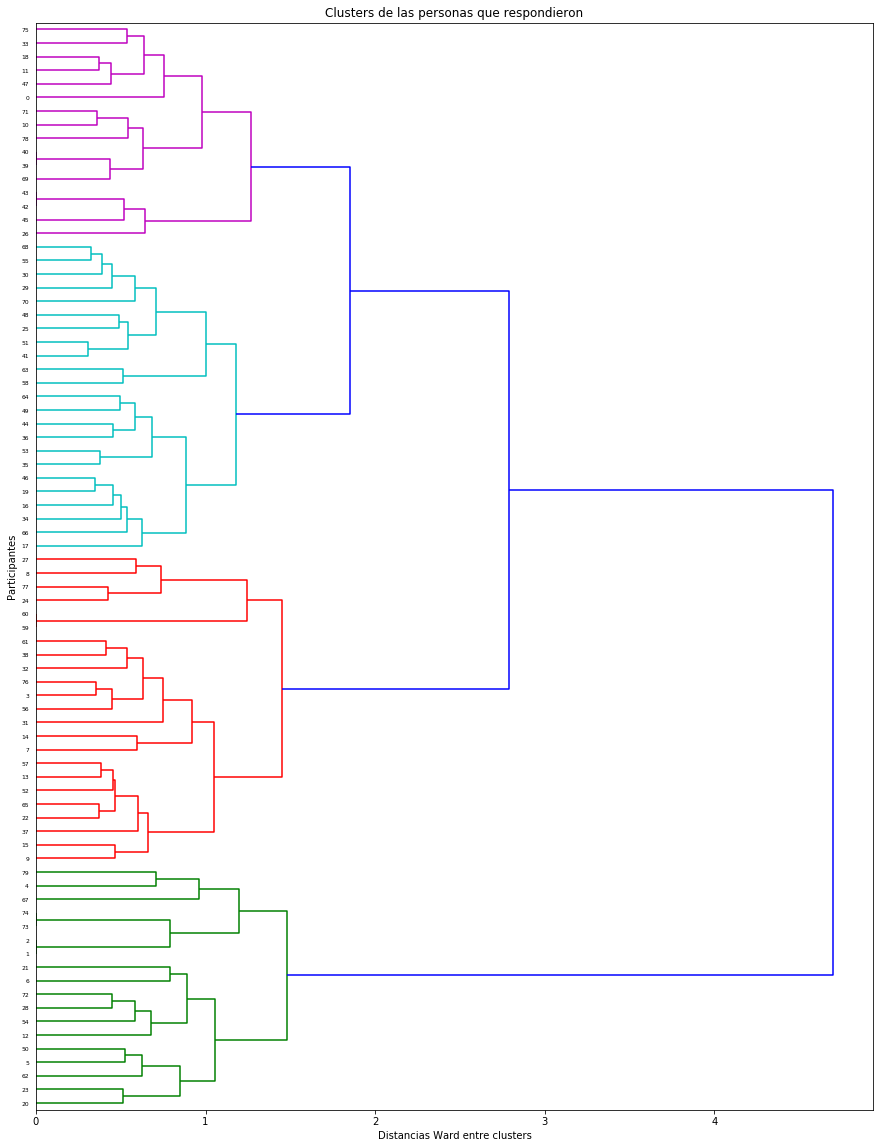

In [72]:
# Dendrograma de las personas

# Elegimos una distancia de corte
# para resaltar los clusters principales
dist_corte_pers = 1.5

fig, ax = plt.subplots(figsize=(15, 20))
opciones = {'ax': ax, 'orientation': "right",
            'p': 5, 'color_threshold': dist_corte_pers,
           }
plt.title('Clusters de las personas que respondieron')
plt.xlabel('Distancias Ward entre clusters')
plt.ylabel('Participantes')
dendrogram(lnk_pers, **opciones)
# Guardamos la imagenresps_
plt.savefig('figuras/dendrograma_personas.png', dpi=150)
plt.show()

In [73]:
# Lista de clusters principales de respuestas y personas
# Los determinamos con la distancia de corte correspondiente
clsts_resps = fcluster(lnk_resps, dist_corte_resps, criterion='distance')
clsts_pers = fcluster(lnk_pers, dist_corte_pers, criterion='distance')
clsts_resps, clsts_pers

(array([2, 2, 1, 1, 1, 1, 4, 1, 3, 1], dtype=int32),
 array([4, 1, 1, 2, 1, 1, 1, 2, 2, 2, 4, 4, 1, 2, 2, 2, 3, 3, 4, 3, 1, 1,
        2, 1, 2, 3, 4, 2, 1, 3, 3, 2, 2, 4, 3, 3, 3, 2, 2, 4, 4, 3, 4, 4,
        3, 4, 3, 4, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 2, 2, 2, 1, 3, 3, 2,
        3, 1, 3, 4, 3, 4, 1, 1, 1, 4, 2, 2, 4, 1], dtype=int32))

In [74]:
def get_cluster(textos, labels, indice):
    ''' Función que devuelve los documentos y títulos de un cluster determinado '''
    cluster_texts = []
    for i, t in enumerate(textos):
        if labels[i] == indice + 1:
            cluster_texts.append(t)
    return cluster_texts

In [75]:
def draw_cluster_spacy(textos, labels, indice, archivo='', **kwargs):
    ''' Función que dibuja la nube de puntos correspondiente a un cluster '''
    txts_cluster = get_cluster(textos, labels, indice)
    pals = ' '. join([
        ' '.join([w.text.lower() for w in txt if w.is_alpha and not w.is_stop and len(w.text) > 3])
            for txt in txts_cluster])
    wordcloud = WordCloud(**kwargs).generate(pals)

    # Display the generated image:
    if archivo:
        plt.title(os.path.basename(archivo))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    if archivo:
        wordcloud.to_file(archivo + '.png' )

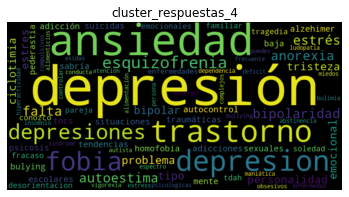

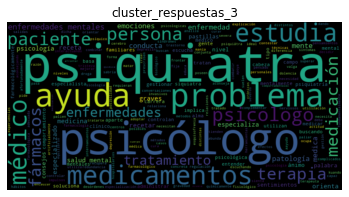

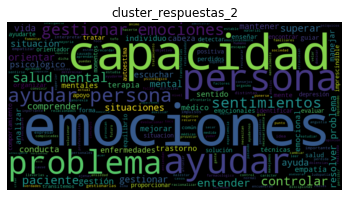

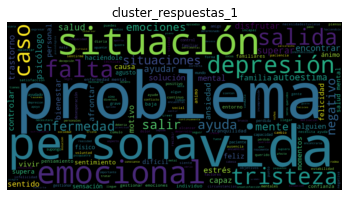

In [76]:
# Nubes de palabras para cada cluster de respuestas
# Se imprimen en orden inverso al número de cluster, para que coincidan con el orden
# en el dendograma
for i in range(3, -1, -1):
    fn = f"figuras/cluster_respuestas_{i+1}"
    draw_cluster_spacy(resps, clsts_resps, i, archivo=fn, width=800, height=400)

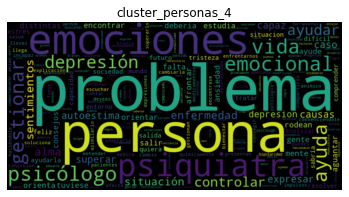

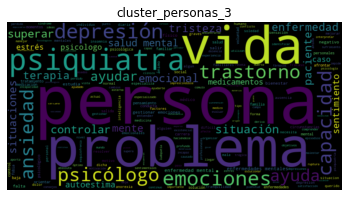

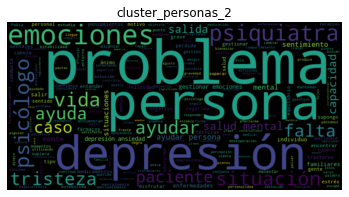

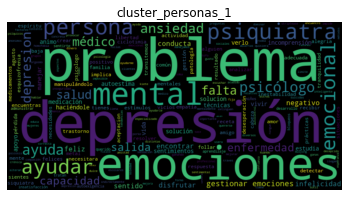

In [77]:
# Nubes de palabras para cada cluster de personas
# Se imprimen en orden inverso al número de cluster, para que coincidan con el orden
# en el dendograma
for i in range(3, -1, -1):
    fn = f"figuras/cluster_personas_{i+1}"
    draw_cluster_spacy(pers, clsts_pers, i, archivo=fn, width=800, height=400)

In [78]:
# Usamos "Análisis de componentes principales" para reducir cada vector de documento a dos dimensiones
# de forma que puedan graficarse
pca = PCA( n_components=2)
pca_resps = pca.fit_transform(v_resps)
pca_pers = pca.fit_transform(v_pers)

/home/ftornay/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ftornay/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


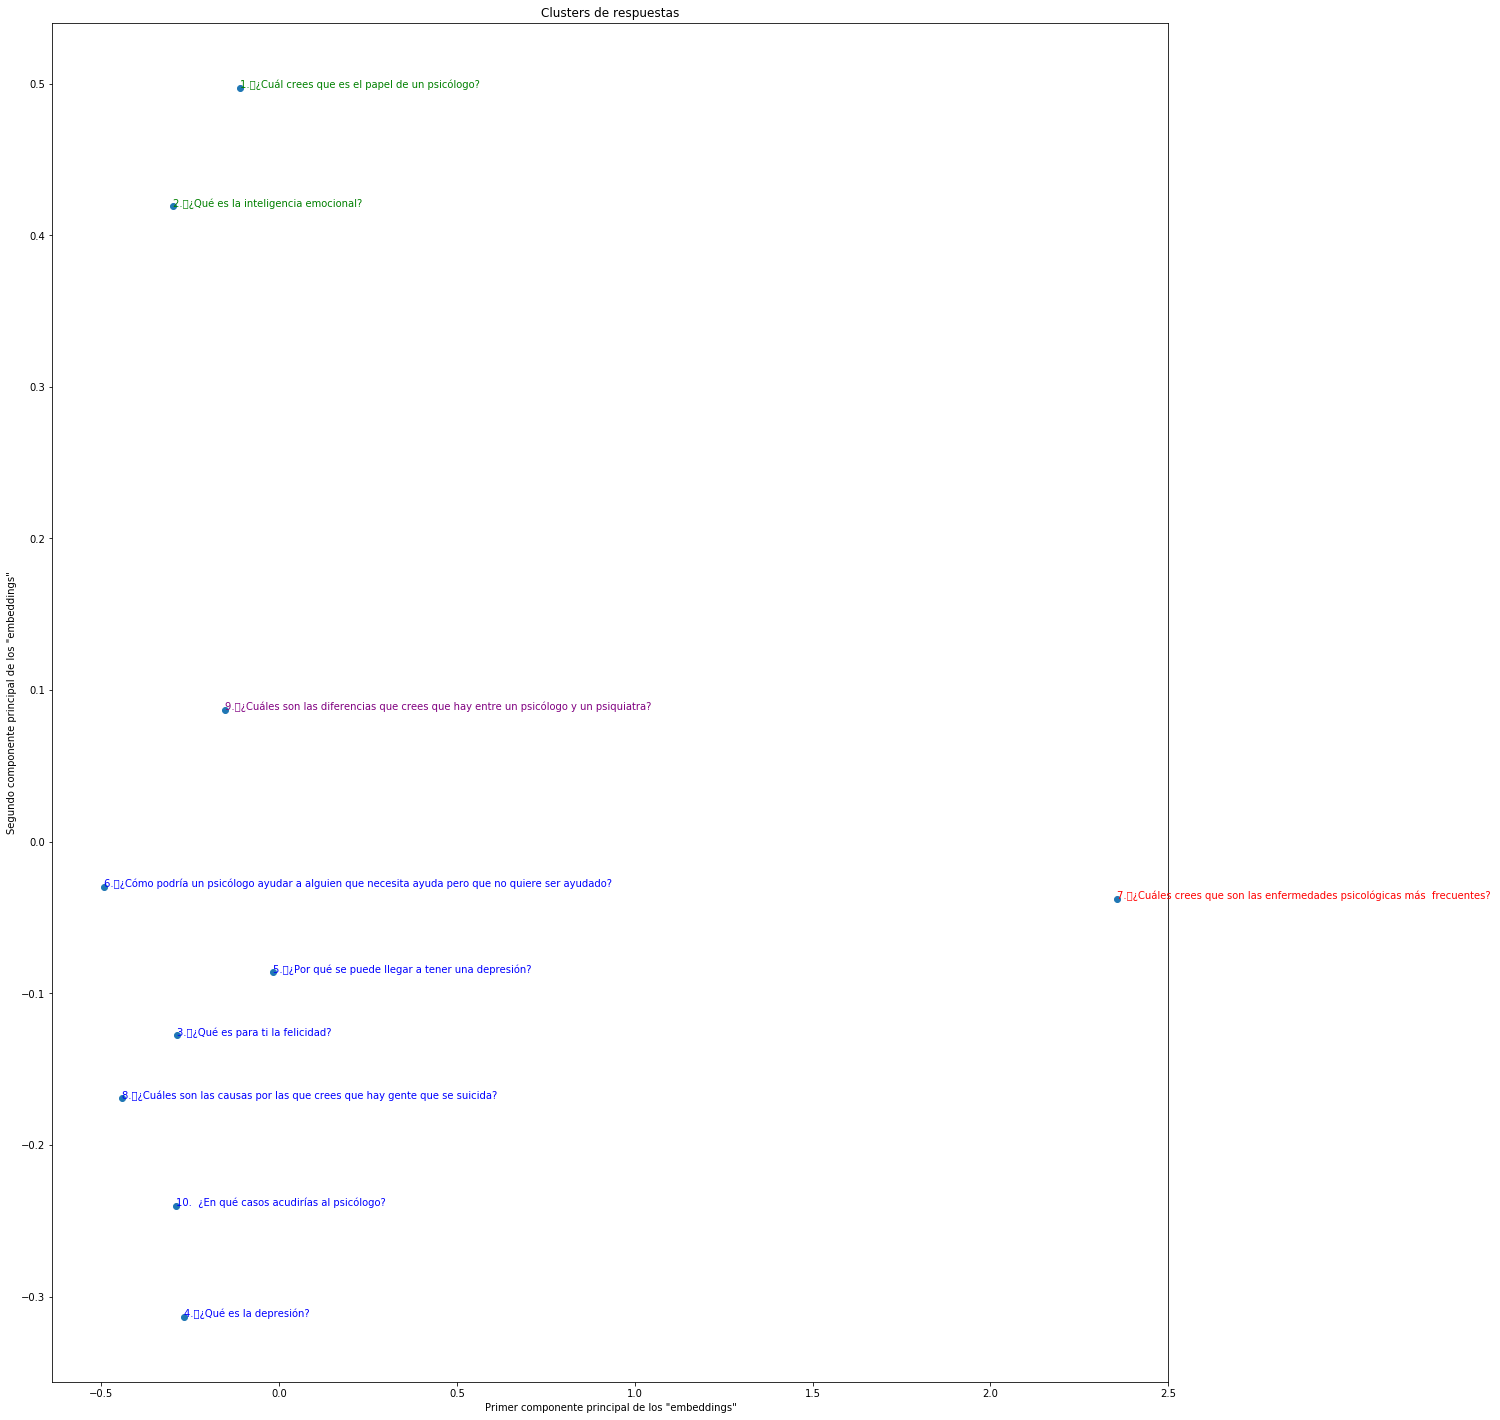

In [79]:
# Colores para cada cluster, equivalentes a los del dendrograma
colores_resps = dict(zip(range(1, 5), ['blue', 'green', 'purple', 'red']))

# Ahora podemos dibujar cada vector en un espacio bidimensional
fig, ax = plt.subplots(figsize=(20, 25))
plt.title('Clusters de respuestas')
plt.xlabel('Primer componente principal de los "embeddings"')
plt.ylabel('Segundo componente principal de los "embeddings"')
ax.scatter(pca_resps[:, 0], pca_resps[:, 1])
# Escribimos cada título con un color correspondiente a su cluster
for i, preg in enumerate(pregs.columns[1:]):
    ax.annotate(preg, xy=(pca_resps[i, 0], pca_resps[i, 1]), c=colores_resps[clsts_resps[i]])
# Guardamos la imagen
plt.savefig('figuras/espacio_respuestas.png', dpi=300)
plt.show()

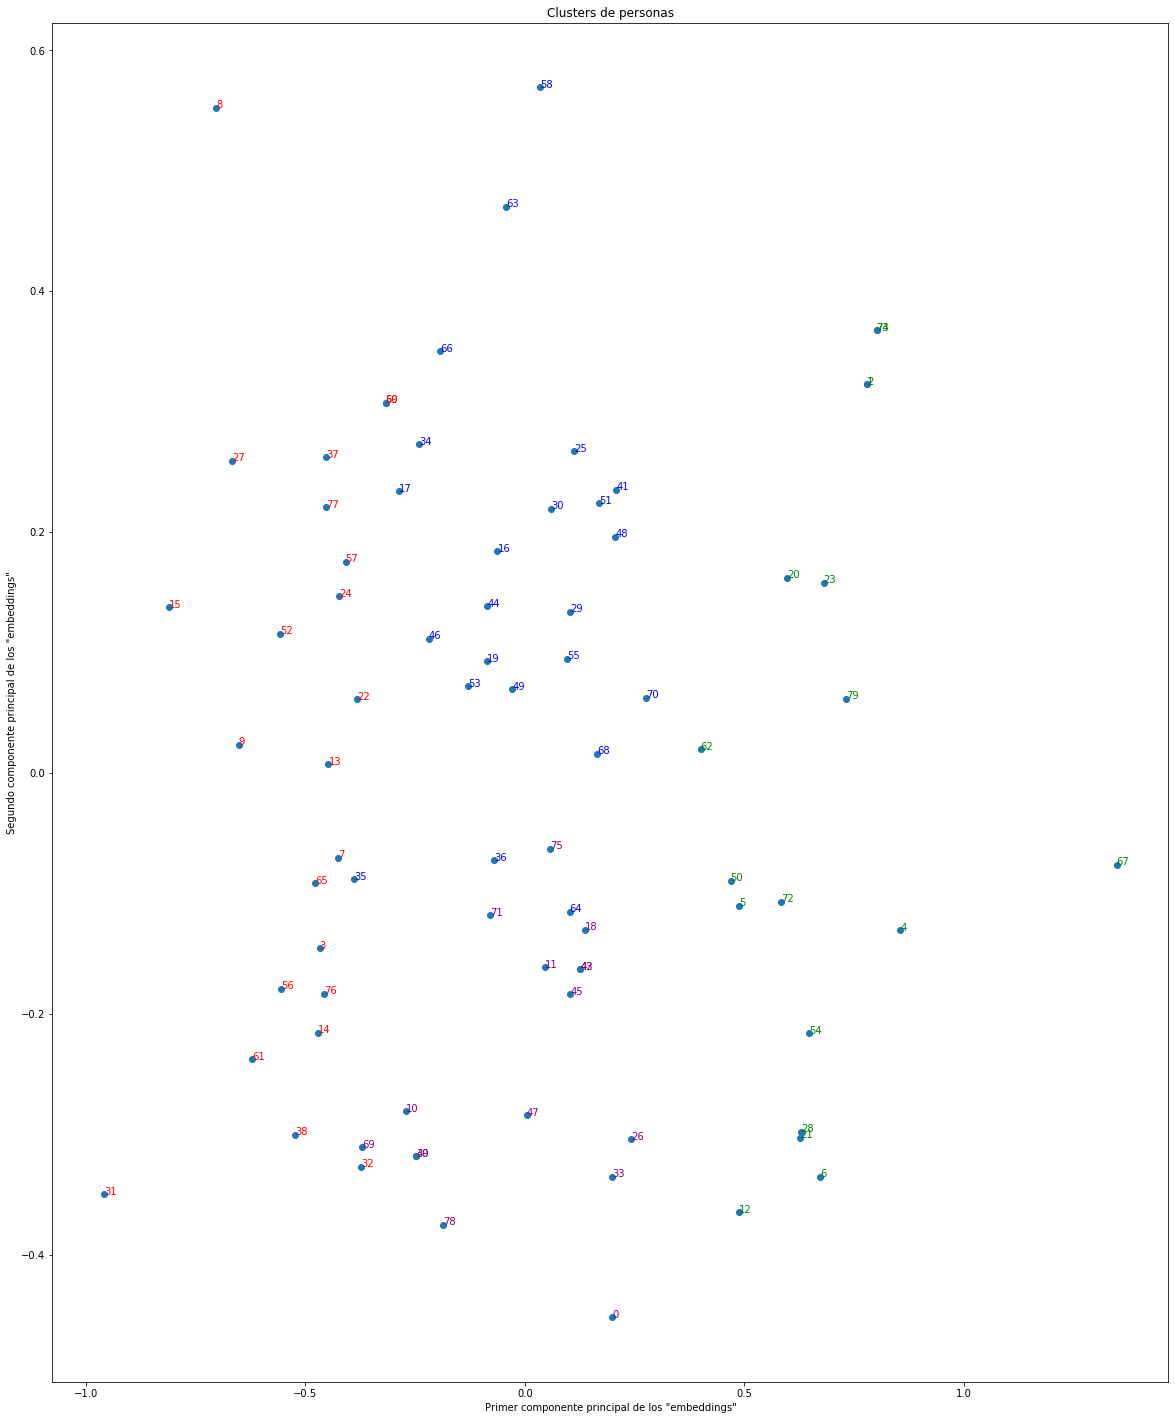

In [80]:
# Colores para cada cluster, equivalentes a los del dendrograma
colores_pers = dict(zip(range(1, 5), ['green', 'red', 'blue', 'purple']))

# Ahora podemos dibujar cada vector en un espacio bidimensional
fig, ax = plt.subplots(figsize=(20, 25))
plt.title('Clusters de personas')
plt.xlabel('Primer componente principal de los "embeddings"')
plt.ylabel('Segundo componente principal de los "embeddings"')
ax.scatter(pca_pers[:, 0], pca_pers[:, 1])
# Escribimos cada título con un color correspondiente a su cluster
for i in range(pregs.shape[0]):
    ax.annotate(i, xy=(pca_pers[i, 0], pca_pers[i, 1]), c=colores_pers[clsts_pers[i]])
# Guardamos la imagen
plt.savefig('figuras/espacio_respuestas.png', dpi=300)
plt.show()